In [91]:
import pandas as pd
import pickle
import numpy as np
from datetime import datetime, timedelta
from EM import EM
import matplotlib.pyplot as plt

### TO DO
* Don't drop all the treatments before the first measurements. Depending on how far we want to look back (another thing to specify), keep the relevant ones

In [2]:
cdm_t = pd.read_pickle('../Data/cdm_t.pkl')
cdm_s = pd.read_pickle('../Data/cdm_s.pkl')

### Data Query Specification

In [95]:
# store signal names and their matching contexts
# key: signal name, e.g. inr
# value: (treatment_names, chronic_keywords, demographic_names)
# treatment_names: dict, key: treatment category e.g. anticoagulant, value: list of relevant fields, e.g. warfarin_dose
# chronic keywords: list, e.g. liver disease
# each signal is specified by a block of cell
signal_context = {}

In [96]:
signal_name = 'inr'

treatment_names = {}
treatment_names['nsaid'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose']
treatment_names['anticoagulant'] = ['warfarin_dose','heparin_dose','dabigatran_dose','edoxaban_dose','rivaroxaban_dose',
'apixaban_dose','enoxaparin_dose','dalteparin_dose','fondaparinux_dose']
treatment_names['transfusion_plasma'] = ['transfuse_plasma']
treatment_names['transfusion_platelets'] = ['transfuse_platelets']
treatment_names['aspirin'] = ['aspirin_dose']

# chronic dict is keyed on the keywords of the chronic conditions we care about
# the keywords are specified in chronic_keywords
# the value is a list of all the features in cdm_s that contain that keyword
chronic_keywords = ['liver_disease', 'sickle_cell']

demographic_names = ['age']

signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [157]:
signal_name = 'creatinine'

treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['nephrotoxic_drugs'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose', 'aminoglycoside', 'radiographic']
treatment_names['interference_drugs'] = ['dronedarone_dose', 'cimetidine', 'trimethoprim_dose', 'cefoxitin',
                                         'flucytosine', 'cobicistat', 'ranitidine', 'famotidine']
treatment_names['dehydration'] = []

chronic_keywords = ['kidney', 'rhabdomyolysis', 'sickle_cell', 'nephrotic', 
                    'renal', 'esrd', 'urine', 'diabetes']

demographic_names = ['age', 'gender', 'admit_weight']

In [158]:
# fill in chronic name dict
chronic_names = {}
all_chronic = cdm_s.loc[:, 'fid'].unique()
for name in chronic_keywords:
    chronic_names[name] = [s for s in all_chronic if name in s]

In [159]:
chronic_names

{'kidney': ['chronic_kidney_final_diag',
  'chronic_kidney_hist',
  'kidney_cancer_icd9_prob',
  'chronic_kidney_diag',
  'chronic_kidney_prob',
  'kidney_cancer_icd9_hist',
  'kidney_cancer_icd9_diag'],
 'rhabdomyolysis': [],
 'sickle_cell': ['sickle_cell_trait_final_diag',
  'sickle_cell_trait_hist',
  'sickle_cell_wo_crisis_hist',
  'sickle_cell_crisis_final_diag',
  'sickle_cell_crisis_prob',
  'sickle_cell_wo_crisis_diag',
  'sickle_cell_wo_crisis_final_diag',
  'sickle_cell_trait_prob',
  'sickle_cell_crisis_diag',
  'sickle_cell_crisis_hist',
  'sickle_cell_wo_crisis_prob',
  'sickle_cell_trait_diag'],
 'nephrotic': [],
 'renal': ['renal_insufficiency_hist', 'renal_insufficiency_diag'],
 'esrd': ['esrd_final_diag', 'esrd_hist', 'esrd_prob', 'esrd_diag'],
 'urine': [],
 'diabetes': ['diabetes_hist', 'diabetes_diag'],
 'failure': ['heart_failure_hist', 'heart_failure_diag']}

In [128]:
all_features = cdm_t['fid'].unique()

In [161]:
for feat in all_features:
    if 'surgery' in feat:
        print(feat)
    for category, names in treatment_names.items():
        for name in names:
            if name in feat:
                print(feat)

ibuprofen_dose
ketorolac_dose
acetaminophen_dose
dialysis
dronedarone_dose
celecoxib_dose
indomethacin_dose
naproxen_dose
diclofenac_dose
meloxicam_dose
trimethoprim_dose


### Preprocessing Parameters

In [67]:
# the least number of signal observation a patient needs to have to be included
cutoff = 5

# bin_size is a offset alias used by the resample method
bin_size = '18H'
bin_size_num = 18

# the maximum percent of missingness allowed in observations for each individual
max_missing_pct = .4
# least number of training observations allowed for each individual
# (number of training observation is calculated based on the training pct specified below)
num_training_obs = 4

# number of past time points where treatment effects are considered
num_past_effects = 3

### Model Training Parameters

In [4]:
# EM Setting
training_pct = .8
single_effect = False

In [6]:
# put all the treatment names into a list to get the corresponding columns
treatment_list = []
for name in treatment_names.values():
    treatment_list.append(name)
# flatten the list
treatment_list = [item for sublist in treatment_list for item in sublist]

### Preprocessing

In [7]:
# df_t is part of the original dataframe that has all the ids who have measurements for the signal we are interested 
# in
signal = cdm_t.loc[cdm_t.loc[:, 'fid'] == signal_name, 'value']
ids = np.unique(cdm_t.loc[signal.index, 'enc_id'])
df_t = cdm_t.loc[cdm_t.loc[:, 'enc_id'].isin(ids), :]

In [8]:
# df_t is now part of the dataframe that contains only the rows with fid being either the signal or the treatments
df_t = df_t.loc[df_t.loc[:, 'fid'].isin(treatment_list + [signal_name]), :]

In [9]:
# convert tsp field to python datetime object
df_t.loc[:, 'tsp'] = df_t.loc[:, 'tsp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S+%f'))
#df_t.loc[:, 'tsp'] = df_t.groupby('enc_id')['tsp'].apply(lambda x: x - x.iloc[0])

In [10]:
# for each id, adjust tsp so that time is zero for the first time the signal is measured
adjusted_time = df_t.groupby('enc_id').apply(lambda x: x.loc[:, 'tsp'] - x.loc[x.loc[:, 'fid'] == signal_name, 'tsp'].iloc[0])
# adjusted_time is multiindexed, need to drop one level before assigning it to column tsp
adjusted_time.index = adjusted_time.index.droplevel()
df_t.loc[:, 'tsp_adjusted'] = adjusted_time

In [11]:
# cut the dataframe based on a cutoff number on the number of signal measurement a patient has
keep_index = df_t.groupby('enc_id')['fid'].filter(lambda x: x.value_counts().loc['inr'] >= cutoff).index
df_t_cut = df_t.loc[keep_index].copy()

In [12]:
# delete rows whose adjusted time is less than the earliest treatment effect we wish to consider
df_t_cut = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(hours=-num_past_effects*bin_size_num), :]

In [13]:
# delete rows before the first observation
#df_t_cut = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(), :]

#adjusted_time = df_t_cut.groupby('enc_id').apply(lambda x: x.loc[:, 'tsp_adjusted']-x.loc[:, 'tsp_adjusted'].iloc[0])
#adjusted_time.index = adjusted_time.index.droplevel()
#df_t_cut.loc[:, 'tsp_adjusted'] = adjusted_time

In [14]:
df_t_cut

,dataset_id,enc_id,tsp,fid,value,confidence,tsp_adjusted
84516,3,1020,2014-04-23 15:41:00,heparin_dose,"{""dose"": 5000.0, ""order_tsp"": ""2014-04-23 15:4...",4,-3 days +20:29:00
84575,3,1020,2014-04-23 17:55:00,heparin_dose,"{""dose"": 1000.0, ""order_tsp"": ""2014-04-23 17:0...",4,-3 days +22:43:00
84601,3,1020,2014-04-23 18:55:00,heparin_dose,"{""dose"": 1000.0, ""order_tsp"": ""2014-04-23 17:0...",4,-3 days +23:43:00
84619,3,1020,2014-04-23 19:55:00,heparin_dose,"{""dose"": 1000.0, ""order_tsp"": ""2014-04-23 17:0...",4,-2 days +00:43:00
84635,3,1020,2014-04-23 20:55:00,heparin_dose,"{""dose"": 1000.0, ""order_tsp"": ""2014-04-23 17:0...",4,-2 days +01:43:00
84644,3,1020,2014-04-23 21:30:00,aspirin_dose,"{""dose"": 325.0, ""order_tsp"": ""2014-04-23 17:42...",1,-2 days +02:18:00
84682,3,1020,2014-04-24 07:54:00,aspirin_dose,"{""dose"": 325.0, ""order_tsp"": ""2014-04-23 17:42...",1,-2 days +12:42:00
84712,3,1020,2014-04-24 14:41:00,heparin_dose,"{""dose"": 1100.0, ""order_tsp"": ""2014-04-23 17:0...",4,-2 days +19:29:00
84716,3,1020,2014-04-24 15:15:00,heparin_dose,"{""dose"": 1100.0, ""order_tsp"": ""2014-04-23 17:0...",4,-2 days +20:03:00
84737,3,1020,2014-04-24 23:02:00,heparin_dose,"{""dose"": 2000.0, ""order_tsp"": ""2014-04-23 17:4...",4,-1 days +03:50:00


In [15]:
%%capture
# create column for the signal
df_t_cut.loc[:, signal_name] = df_t_cut.loc[df_t_cut.loc[:, 'fid'].isin([signal_name]), 'value']
df_t_cut.loc[:, signal_name] = df_t_cut.loc[:, signal_name].apply(lambda x: float(x))

In [16]:
%%capture
# create a column for each treatment category
# binarize
for category, names in treatment_names.items():
    df_t_cut.loc[:, category] = df_t_cut.loc[df_t_cut.loc[:, 'fid'].isin(names), 'value']
for treatment in treatment_names.keys():
    df_t_cut.loc[df_t_cut.loc[:, treatment].notna(), treatment] = 1
    df_t_cut.loc[:, treatment] = df_t_cut.loc[:, treatment].fillna(value = 0)

In [17]:
# for every patient, delete all rows after the last valid signal measurement 
df_t_cut = df_t_cut.groupby('enc_id').apply(lambda x: x.loc[x.index <= x.loc[:, 'inr'].last_valid_index(), :]).reset_index(drop=True)

In [18]:
# put signals in bins
binned_signal = df_t_cut.loc[:, ['enc_id', 'tsp_adjusted', signal_name]].dropna().groupby('enc_id').apply(lambda x: x.loc[:, ['tsp_adjusted', signal_name]].resample(bin_size, on='tsp_adjusted', base=0).mean())
binned_signal.reset_index(level='enc_id', inplace=True)
new_times = binned_signal.index.get_level_values('tsp_adjusted')
binned_signal.loc[:, 'time'] = new_times
binned_signal.reset_index(drop=True, inplace=True)

In [19]:
binned_signal

,enc_id,inr,time
0,1020,1.000,0 days 00:00:00
1,1020,2.600,0 days 18:00:00
2,1020,NaN,1 days 12:00:00
3,1020,6.500,2 days 06:00:00
4,1020,4.700,3 days 00:00:00
5,1020,2.400,3 days 18:00:00
6,1221,2.050,0 days 00:00:00
7,1221,NaN,0 days 18:00:00
8,1221,4.200,1 days 12:00:00
9,1221,3.100,2 days 06:00:00


In [20]:
# seperate the rows with positive and negative time to different dataframe to do resampling

# every row with nonnegative time
df_t_pos = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(), :]
# every row with nonpositive time
df_t_neg = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] <= timedelta(), :]

In [21]:
%%capture
# make all the negative time positive, so the largest value is the time point farthest out
# necessary because resampling starts from the smallest time, we want it to be zero
df_t_neg.loc[:, 'tsp_adjusted'] = df_t_neg.loc[:, 'tsp_adjusted'].apply(lambda x: -x)

In [22]:
# binned treatments for time points prior to the first signal observation
binned_treatment_prev = df_t_neg.loc[:, ['enc_id', 'tsp_adjusted']+ list(treatment_names.keys())].groupby('enc_id').apply(lambda x: x.resample(bin_size, on='tsp_adjusted').max())
binned_treatment_prev.loc[:, 'enc_id'].fillna(method='bfill', inplace=True)
binned_treatment_prev.fillna(0, inplace=True)
new_times = binned_treatment_prev.index.get_level_values('tsp_adjusted')
binned_treatment_prev.reset_index(drop=True, inplace=True)
binned_treatment_prev.loc[:, 'time'] = new_times

In [23]:
# for some patient there are no treatments before the first observation
# but to allow the model to work consistently, we add rows with all zeros to those patients
def add_rows_treatment(x):
    last_time = x.loc[:, 'time'].iloc[-1]
    while last_time < timedelta(hours=(num_past_effects-1)*bin_size_num):
        last_row = x.iloc[-1, :]
        new_last_time = last_time + timedelta(hours=bin_size_num)
        last_row.loc['time'] = new_last_time
        last_row.loc[list(treatment_names.keys())] = 0
        last_time = new_last_time
        x = x.append(last_row)
    return x

binned_treatment_prev = binned_treatment_prev.groupby('enc_id').apply(lambda x: add_rows_treatment(x))
binned_treatment_prev.reset_index(drop=True, inplace=True)

In [24]:
# adjust time so that the farthest out time point is time zero
positive_time = binned_treatment_prev.groupby('enc_id').apply(lambda x: (x.loc[:, 'time'].iloc[-1]-x.loc[:, 'time']))
positive_time.reset_index(drop=True, inplace=True)
binned_treatment_prev.loc[:, 'time'] = positive_time

In [25]:
# flip row order so| time is in increasing order
binned_treatment_prev = binned_treatment_prev.groupby('enc_id').apply(lambda x: x.iloc[::-1])
binned_treatment_prev.reset_index(drop=True, inplace=True)

In [26]:
# treatments prior to the first observation is stored seperatedly from those after
# so signals and treatments after the first observation can use the same starting time point
binned_treatment_prev

,enc_id,tsp_adjusted,nsaid,anticoagulant,transfusion_plasma,transfusion_platelets,aspirin,time
0,1020.0,2 days 03:31:00,0.0,1.0,0.0,0.0,1.0,0 days 00:00:00
1,1020.0,1 days 11:18:00,0.0,1.0,0.0,0.0,1.0,0 days 18:00:00
2,1020.0,0 days 12:58:00,0.0,1.0,0.0,0.0,1.0,1 days 12:00:00
3,1221.0,0 days 03:42:00,0.0,0.0,0.0,0.0,0.0,0 days 00:00:00
4,1221.0,0 days 03:42:00,0.0,0.0,0.0,0.0,0.0,0 days 18:00:00
5,1221.0,0 days 03:42:00,0.0,1.0,0.0,0.0,0.0,1 days 12:00:00
6,1319.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0 days 00:00:00
7,1319.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0 days 18:00:00
8,1319.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,1 days 12:00:00
9,1330.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0 days 00:00:00


In [27]:
# resampling for treatments after the first signal observation
# the first time point for each patient is num_past_effects*bin_size_num
binned_treatment_post = df_t_pos.loc[:, ['enc_id', 'tsp_adjusted']+ list(treatment_names.keys())].groupby('enc_id').apply(lambda x: x.resample(bin_size, on='tsp_adjusted').max())
# since the last id should not be nan, use bfill to fill the id column
# it's important for id column to be correct since we use it to combine prev and post binned treatments
#binned_treatment_post.loc[:, 'enc_id'].fillna(method='bfill', inplace=True)
binned_treatment_post.fillna(0, inplace=True)
new_time = binned_treatment_post.index.get_level_values('tsp_adjusted') #+ timedelta(hours=num_past_effects*bin_size_num)
binned_treatment_post.loc[:, 'time'] = new_time
binned_treatment_post.reset_index(drop=True, inplace=True)

In [28]:
binned_treatment_post

,enc_id,tsp_adjusted,nsaid,anticoagulant,transfusion_plasma,transfusion_platelets,aspirin,time
0,1020.0,0 days 12:46:00,0.0,1.0,0.0,0.0,1.0,0 days 00:00:00
1,1020.0,1 days 11:22:00,0.0,1.0,0.0,0.0,0.0,0 days 18:00:00
2,1020.0,1 days 22:15:00,0.0,1.0,0.0,0.0,1.0,1 days 12:00:00
3,1020.0,2 days 13:20:00,0.0,0.0,0.0,0.0,1.0,2 days 06:00:00
4,1020.0,3 days 14:23:00,0.0,0.0,0.0,0.0,1.0,3 days 00:00:00
5,1020.0,4 days 11:59:00,0.0,1.0,0.0,0.0,0.0,3 days 18:00:00
6,1221.0,0 days 16:44:00,0.0,1.0,0.0,0.0,0.0,0 days 00:00:00
7,1221.0,1 days 05:41:00,0.0,1.0,0.0,0.0,1.0,0 days 18:00:00
8,1221.0,1 days 20:55:00,0.0,0.0,0.0,0.0,1.0,1 days 12:00:00
9,1221.0,2 days 19:54:00,0.0,0.0,0.0,0.0,1.0,2 days 06:00:00


In [29]:
%%capture
'''
# put the binned treatment together
binned_treatment_list = []
for i in np.unique(binned_signal.loc[:, 'enc_id']):
    prev = binned_treatment_prev.loc[binned_treatment_prev.loc[:, 'enc_id']==i, :]
    post = binned_treatment_post.loc[binned_treatment_post.loc[:, 'enc_id']==i, :]
    binned_treatment_list.append(pd.concat([prev, post]))

binned_treatment_combined = pd.concat(binned_treatment_list)
binned_treatment_combined.reset_index(drop=True, inplace=True)

# adjust time points for signal so that the first observation starts from time num_past_effects * bin_size_num
binned_signal.loc[:, 'time'] += timedelta(hours=num_past_effects*bin_size_num)

# for each id, signals for the first num_past_effects time points are nan
# those are used as placeholder so that the dimension of signal matrix matches that of the treatment matrix
def add_rows_signal(x):
    x = x.iloc[::-1]
    first_time = x.loc[:, 'time'].iloc[-1]
    while first_time > timedelta():
        new_first_time = first_time - timedelta(hours=bin_size_num)
        row = x.iloc[0]
        row[signal_name] = np.nan
        row['time'] = new_first_time
        first_time = new_first_time
        x = x.append(row)
    return x.iloc[::-1]

binned_signal = binned_signal.groupby('enc_id').apply(lambda x: add_rows_signal(x)).reset_index(drop=True)
'''

In [30]:
# contain binned signal and treatments starting from the first observation
# the first observation for each id is time zero
df_binned = pd.concat([binned_signal, binned_treatment_post.loc[:, list(treatment_names.keys())]], axis = 1)

In [31]:
df_binned

,enc_id,inr,time,nsaid,anticoagulant,transfusion_plasma,transfusion_platelets,aspirin
0,1020,1.000,0 days 00:00:00,0.0,1.0,0.0,0.0,1.0
1,1020,2.600,0 days 18:00:00,0.0,1.0,0.0,0.0,0.0
2,1020,NaN,1 days 12:00:00,0.0,1.0,0.0,0.0,1.0
3,1020,6.500,2 days 06:00:00,0.0,0.0,0.0,0.0,1.0
4,1020,4.700,3 days 00:00:00,0.0,0.0,0.0,0.0,1.0
5,1020,2.400,3 days 18:00:00,0.0,1.0,0.0,0.0,0.0
6,1221,2.050,0 days 00:00:00,0.0,1.0,0.0,0.0,0.0
7,1221,NaN,0 days 18:00:00,0.0,1.0,0.0,0.0,1.0
8,1221,4.200,1 days 12:00:00,0.0,0.0,0.0,0.0,1.0
9,1221,3.100,2 days 06:00:00,0.0,0.0,0.0,0.0,1.0


In [32]:
# take only part of cdm_s that has the patient ids which we use in df_binned
df_s = cdm_s.loc[cdm_s.loc[:, 'enc_id'].isin(df_binned.loc[:, 'enc_id'].unique()), :]

In [33]:
# create dataframe containing each chronic conditions, binarize
df_static = pd.DataFrame()
for chronic, names in chronic_names.items():
    col = df_s.groupby('enc_id').apply(lambda x: x.loc[x.loc[:, 'fid'].isin(names), 'value'].any())
    df_static.loc[:, chronic] = col # to make sure index is correct
    df_static.loc[:, chronic] = np.where(col == False, 0, 1)

In [34]:
# add demographic information to df_static
for demo in demographic_names:
    col = df_s.groupby('enc_id').apply(lambda x: int(x.loc[x.loc[:, 'fid'] == demo, 'value'].values[0]))
    df_static.loc[:, demo] = col

In [35]:
df_static

,liver_disease,sickle_cell,age
enc_id,,,
1020,0,0,56
1221,0,0,89
1319,0,0,88
1330,0,0,90
1337,0,0,68
1575,0,0,82
1602,0,0,72
1793,0,0,80
1905,0,0,83


In [68]:
# remove individuals with observation missing pct larger than the threshold
df_binned = df_binned.groupby('enc_id').filter(lambda x: (np.where(x.loc[:, signal_name].isna())[0].shape[0]) / x.shape[0] < max_missing_pct)
# remove individuals with num training obs less than the a threshold
df_binned = df_binned.groupby('enc_id').filter(lambda x: int(np.where(np.invert(np.isnan(x.loc[:, signal_name])))[0].shape[0]*training_pct) >= num_training_obs)
# the number of ids available for training
num_unique_ids = np.unique(df_binned.loc[:, 'enc_id']).shape[0]
num_unique_ids

1821

In [69]:
# also remove the individuals with high missing pct and small number of training obs
# from df_static and binned_treatment_prev
df_static = df_static.loc[np.unique(df_binned.loc[:, 'enc_id']), :]
binned_treatment_prev = binned_treatment_prev.groupby('enc_id').filter(lambda x: x.loc[:, 'enc_id'].iloc[0] in np.unique(df_binned.loc[:, 'enc_id']))

In [72]:
# overall percentage of missing observations after removal
np.where(df_binned.loc[:, signal_name].isnull())[0].shape[0]/df_binned.shape[0]

0.2304432367751907

In [73]:
# maximum number of bins for an individual
# necessary if convert dataframe to np array
max_num_bins = int(max(df_binned.loc[:, 'time']) / timedelta(hours=bin_size_num)) + 1

In [74]:
# turn static features into np array
c_mtx = df_static.values

In [75]:
# create matrix storing the signal observations
# shape is (number of patient * max_num_bins)
y_list = []
df_binned.groupby('enc_id').apply(lambda x: y_list.append(x.loc[:, signal_name].values))
# for some reason the first group always got appended twice to the list, so delete one
y_list.pop(0)
y_mtx = np.full((len(y_list), max_num_bins), np.nan)
for i, y in enumerate(y_list):
    y_mtx[i, :y.shape[0]] = y

In [76]:
# create matrix storing treatment (after the first observation) information
# shape is (number of patients * max_num_bins * number of treatment categories)
x_list = []
df_binned.groupby('enc_id').apply(lambda x: x_list.append(x.loc[:, list(treatment_names.keys())].values))
x_list.pop(0)
X_mtx = np.zeros((len(x_list), max_num_bins, len(treatment_names.keys())))
for i, x in enumerate(x_list):
    X_mtx[i, :x.shape[0], :] = x

In [77]:
# create matrix storing treatment (before the first observation) information
# shape is (number of patients * num_past_effects * number of treatment categories)
x_prev_list = []
binned_treatment_prev.groupby('enc_id').apply(lambda x: x_prev_list.append(x.loc[:, list(treatment_names.keys())].values))
x_prev_list.pop(0)
X_prev_mtx = np.zeros((len(x_prev_list), num_past_effects, len(treatment_names.keys())))
for i, x in enumerate(x_prev_list):
    X_prev_mtx[i, :x.shape[0], :] = x

In [84]:
np.savez('../Data/'+signal_name+'_preprocessed_data', y_mtx=y_mtx, X_mtx=X_mtx, X_prev_mtx=X_prev_mtx, c_mtx=c_mtx)

### Model Training

In [85]:
em = EM(y_mtx, X_mtx, c_mtx, num_past_effects, 0, train_pct=training_pct, single_effect=single_effect)

In [87]:
%%time
em = EM(y_mtx, X_mtx, c_mtx, num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
        X_prev = X_prev_mtx, single_effect=single_effect)
em.run_EM(2000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

iteration 594
iteration 595
iteration 596
iteration 597
iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iteration 607
iteration 608
iteration 609
iteration 610
iteration 611
iteration 612
iteration 613
iteration 614
iteration 615
iteration 616
iteration 617
iteration 618
iteration 619
iteration 620
iteration 621
iteration 622
iteration 623
iteration 624
iteration 625
iteration 626
iteration 627
iteration 628
iteration 629
iteration 630
iteration 631
iteration 632
iteration 633
iteration 634
iteration 635
iteration 636
iteration 637
iteration 638
iteration 639
iteration 640
iteration 641
iteration 642
iteration 643
iteration 644
iteration 645
iteration 646
iteration 647
iteration 648
iteration 649
iteration 650
iteration 651
iteration 652
iteration 653
iteration 654
iteration 655
iteration 656
iteration 657
iteration 658
iteration 659
iteration 660
iteration 661
iteration 662
iteration 663
iteration 664
iterat

iteration 1168
iteration 1169
iteration 1170
iteration 1171
iteration 1172
iteration 1173
iteration 1174
iteration 1175
iteration 1176
iteration 1177
iteration 1178
iteration 1179
iteration 1180
iteration 1181
iteration 1182
iteration 1183
iteration 1184
iteration 1185
iteration 1186
iteration 1187
iteration 1188
iteration 1189
iteration 1190
iteration 1191
iteration 1192
iteration 1193
iteration 1194
iteration 1195
iteration 1196
iteration 1197
iteration 1198
iteration 1199
iteration 1200
iteration 1201
iteration 1202
iteration 1203
iteration 1204
iteration 1205
iteration 1206
iteration 1207
iteration 1208
iteration 1209
iteration 1210
iteration 1211
iteration 1212
iteration 1213
iteration 1214
iteration 1215
iteration 1216
iteration 1217
iteration 1218
iteration 1219
iteration 1220
iteration 1221
iteration 1222
iteration 1223
iteration 1224
iteration 1225
iteration 1226
iteration 1227
iteration 1228
iteration 1229
iteration 1230
iteration 1231
iteration 1232
iteration 1233
iteration 

iteration 1715
iteration 1716
iteration 1717
iteration 1718
iteration 1719
iteration 1720
iteration 1721
iteration 1722
iteration 1723
iteration 1724
iteration 1725
iteration 1726
iteration 1727
iteration 1728
iteration 1729
iteration 1730
iteration 1731
iteration 1732
iteration 1733
iteration 1734
iteration 1735
iteration 1736
iteration 1737
iteration 1738
iteration 1739
iteration 1740
iteration 1741
iteration 1742
iteration 1743
iteration 1744
iteration 1745
iteration 1746
iteration 1747
iteration 1748
iteration 1749
iteration 1750
iteration 1751
iteration 1752
iteration 1753
iteration 1754
iteration 1755
iteration 1756
iteration 1757
iteration 1758
iteration 1759
iteration 1760
iteration 1761
iteration 1762
iteration 1763
iteration 1764
iteration 1765
iteration 1766
iteration 1767
iteration 1768
iteration 1769
iteration 1770
iteration 1771
iteration 1772
iteration 1773
iteration 1774
iteration 1775
iteration 1776
iteration 1777
iteration 1778
iteration 1779
iteration 1780
iteration 

In [88]:
treatment_types = ['nsaid', 'transfusion_plasma', 'transfusion_platelet', 'anticoagulant', 'aspirin']
for i, treatment in enumerate(treatment_types):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = ['chronic kidney failure', 'sickle cell', 'age']
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))
print('initial state variance: {}'.format(em.sigma_0))
print('transition noise: {}'.format(em.sigma_1))
print('observation noise: {}'.format(em.sigma_2))

Coefficient for nsaid: [-0.05332823  0.01914507 -0.03836663]
Coefficient for transfusion_plasma: [-0.694217   -0.03495779 -0.0522998 ]
Coefficient for transfusion_platelet: [-0.38430565 -0.15892385 -0.31262086]
Coefficient for anticoagulant: [-0.63994745 -0.74545805 -0.5791365 ]
Coefficient for aspirin: [-0.06409683 -0.06972851  0.0302996 ]
Coefficient for chronic kidney failure: -0.2643214568560729
Coefficient for sickle cell: -0.5218307359528491
Coefficient for age: -0.027047728916270067
initial state variance: 0.00020395166620667873
transition noise: 0.14622894241670079
observation noise: 1.127059127544025


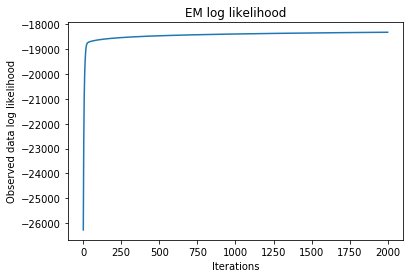

In [92]:
plt.plot([i for i in range(1, len(em.obs_log_lik))], em.obs_log_lik[1:])
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

### Future Improvements
* for now, signals and treatments are stored as np array whose shape is determined by the maximum number of bins an individual has. This is to accomodate the existing code in EM.py, but the resulting matrix has lots of extra nans(in the case of signal) and zeros(in the case of treatments), which could be address by changing the data structure used in the EM.py code